# **Avalanche danger level prediction**
#### *for dry-snow conditions, using Machine Learning*

---

# 0. **Introduction**

In many countries with snow-covered mountain
regions, avalanche warning services regularly
issue forecasts to inform the public and local
authorities about the avalanche hazard. Even
today, these forecasts are prepared by human
experts.

A key component is the avalanche danger level,
usually communicated according to a five-level,
ordinal danger scale, which summarizes
avalanche conditions with regard to different
factors and conditions.

ML models to **classify avalanche risk**
may well have potential to become a valuable
supplementary decision support tool for
avalanche forecasters when assessing avalanche
hazard.

More details about the project can be found in `documentation/`.


---

# 1. **Explorative Data Analysis** (EDA)

In [1]:
# Install dependencies
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import os
import sys
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from joypy import joyplot
from scipy.stats import chi2_contingency

# Set the style of the plots
palette = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

IMG_DIR = os.path.join("..", "results", "EDA", "imgs")
CSV_DIR = os.path.join("..", "results", "EDA", "csv")
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

In [3]:
# Load the data
df = pd.read_csv(os.path.join('..', 'resources', 'data_rf2_tidy.csv'), index_col=0).drop(columns=['set'])   # We already remove 'set' because it's useless

## 1.1 **Dataset description**

>From [_Automated predictions of the avalanche danger level for dry-snow conditions in Switzerland_](https://gitlab.renkulab.io/deapsnow/predictions_avalanche_danger-level_switzerland/-/tree/main/data?ref_type=heads) repository:

These data sets include the meteorological variables (resampled 24-hour averages) and the profile variables extracted from the simulated profiles using SNOWPACK with input data of the weather stations of the IMIS network in Switzerland.  In addition, the data set of _'Data\_RF1\_forecast.csv'_ contains the danger ratings for dry-snow conditions assigned in the Swiss avalanche bulletin to the location of the weather station and the data set of _'Data\_RF2\_tidy.csv'_ a quality-controlled subset of danger ratings for dry-snow conditions.

- **'datum'**: date of the issued avalanche forecast
- **'station_code'**: code of the weather station of the IMIS network
- **'sector_id'**: number code of the region of the location of the weather station
- **'warnreg'**: number code for mapping the warning regions
- **'elevation_station'**: elevation (m a.s.l.) of the weather station
- **'forecast_initial_date'**: initial date and time of the forecast window
- **'forecast_end_date'**: end date and time of the forecast window
- **'dangerLevel'**: danger level assigned according to the five-level European Avalanche Danger Scale (1-Low, 2-Moderate; 3-Considerable, 4-High, and 5-Very High)
- **'elevation_th'**: critical elevation (m a.s.l.) forecast in the bulletin for the region
- **'set'**: training or test set
- **'Qs'**: sensible heat [W/m2]
- **'Ql'**: latent heat [W/m2]
- **'TSG'**: ground temperature [°C]
- **'Qg0'**: ground heat at soil interface [W/m2]
- **'Qr'**: rain energy [W/m2]
- **'OLWR'**: outgoing long wave radiation [W/m2]
- **'ILWR'**: incoming long wave radiation [W/m2]
- **'LWR_net'**: net long wave radiation [W/m2]
- **'OSWR'**: reflected short wave radiation [W/m2]
- **'ISWR'**: incoming short wave radiation [W/m2]
- **'Qw'**: net short wave radiation [W/m2]
- **'pAlbedo'**: parametrized albedo [-]
- **'ISWR_h'**: incoming short wave on horizontal [W/m2]
- **'ISWR_diff'**: direct incoming short wave [W/m2]
- **'ISWR_dir'**: diffuse incoming short wave [W/m2]
- **'TA'**: air temperature [°C]
- **'TSS_mod'**: surface temperature (modelled) [°C]
- **'TSS_meas'**: surface temperature (measured) [°C]
- **'T_bottom'**: bottom temperature [°C]
- **'RH'**: relative humidity [-]
- **'VW'**: wind velocity [m/s]
- **'VW_drift'**: wind velocity drift [m/s]
- **'DW'**: wind direction [°]
- **'MS_Snow'**: solid precipitation rate [kg/m2/h]
- **'HS_mod'**: snow height (modelled) [cm]
- **'HS_meas'**: snow height (measured) [cm]
- **'hoar_size'**: hoar size [cm]
- **'wind_trans24'**: 24h wind drift [cm]
- **'wind_trans24_7d'**: 7d wind drift [cm]
- **'wind_trans24_3d'**: 3d wind drift [cm]
- **'HN24'**: 24h height of new snow [cm]
- **'HN72_24'**: 3d sum of daily height of new snow [cm]
- **'HN24_7d'**: 7d sum of daily height of new snow [cm]
- **'SWE'**: snow water equivalent [kg/m2]
- **'MS_water'**: total amount of water [kg/m2]
- **'MS_Wind'**: erosion mass loss [kg/m2]
- **'MS_Rain'**: rain rate [kg/s2/h]
- **'MS_SN_Runoff'**: virtual lysimeter [kg/s2/h]
- **'MS_Sublimation'**: sublimation mass [kg/m2]
- **'MS_Evap'**: evaporated mass [kg/m2]
- **'TS0'**: snow temperature at 0.25 m [°C]
- **'TS1'**: snow temperature at 0.5 m [°C]
- **'TS2'**: snow temperature at 1 m [°C]
- **'Sclass2'**: stability class [-]
- **'zSd_mean'**: depth of deformation rate stability index [cm]
- **'Sd'**: deformation rate stability index [-]
- **'zSn'**: depth of natural stability index [cm]
- **'Sn'**: natural stability index [-]
- **'zSs'**: depth of natural stability index [cm]
- **'Ss'**: Sk38 skier stability index [-]
- **'zS4'**: depth of Sk38 skier stability index [cm]
- **'S4'**: structural stability index [-]
- **'zS5'**: depth of stability index 5 [cm]
- **'S5'**: stability index 5 [-]
- **'pwl_100'**: Persistent weak layer(s) in the 100 cm from the surface [-]
- **'pwl_100_15'**: Persistent weak layer(s) at depths between 15 cm and 100 cm [-]
- **'base_pwl'**: Persistent weak layer at bottom [-]
- **'ssi_pwl'**: Structural stability index at weak layer [-]
- **'sk38_pwl'**: Sk38 skier stability index at weak layer [-]
- **'sn38_pwl'**: Natural stability index at weak layer [-]
- **'ccl_pwl'**: Critical cut length at weak layer [m]
- **'ssi_pwl_100'**: Structural stability index at surface weak layer [-]
- **'sk38_pwl_100'**: Sk38 skier stability index at surface weak layer [-]
- **'sn38_pwl_100'**: Natural stability index at surface weak layer [-]
- **'ccl_pwl_100'**: Critical cut length at surface weak layer [m]
- **'Pen_depth'**: Skier penetration depth [cm]
- **'min_ccl_pen'**: Minimum critical cut length at a deeper layer of the penetration depth [m]

We can already see that there is a variety of features in the dataset related to different aspects which can influence the avalanche danger level, such as weather (temperature, humidity...), snowpack conditions (snow height, snow temperature...) and stability indices (natural stability index, skier stability index...).

There are also some metadata information such as the weather station and the region code, aspects that should not be taken into account for the creation of a generalized model.

## 1.2 **General info**

In [4]:
# Data shape
print(f"Rows: {df.shape[0]:,}\nColumns: {df.shape[1]}")

Rows: 29,296
Columns: 79


In [5]:
print("Target variable: 'DangerLevel'")
print(f"Type: {df['dangerLevel'].dtype}")
print(f"Unique values: {sorted(df['dangerLevel'].unique().tolist())}")

Target variable: 'DangerLevel'
Type: int64
Unique values: [1, 2, 3, 4, 5]


In [6]:
# Show first few rows
df.head()

,datum,station_code,sector_id,dangerLevel,elevation_th,warnreg,elevation_station,Qs,Ql,Qg_mean,...,ssi_pwl,sk38_pwl,sn38_pwl,ccl_pwl,ssi_pwl_100,sk38_pwl_100,sn38_pwl_100,ccl_pwl_100,Pen_depth,min_ccl_pen
0,2001-12-01,BER3,7112,2,2500.0,15.0,2625.0,6.689875,-4.370125,NaN,...,6.00,6.00,5.41,3.00,6.00,6.00,5.41,3.00,15.510000,4.00
1,2001-12-02,BED2,6111,2,2400.0,15.0,2420.0,14.823625,3.512625,NaN,...,1.96,0.95,2.34,0.33,1.96,0.95,2.34,0.33,16.137946,0.33
2,2001-12-02,BER3,7112,2,2600.0,15.0,2625.0,35.341000,3.784125,NaN,...,6.00,6.00,6.00,4.00,6.00,6.00,6.00,4.00,15.310000,4.00
3,2001-12-05,HTR2,5223,1,1500.0,15.0,2147.0,15.825250,-7.666000,NaN,...,1.20,0.20,4.16,0.35,1.20,0.20,4.16,0.35,16.612166,0.35
4,2001-12-05,HTR3,5223,1,1500.0,15.0,2200.0,11.049250,-3.437500,NaN,...,6.00,6.00,6.00,3.00,6.00,6.00,6.00,3.00,8.470000,4.00


### 1.2.1 Data types

In [7]:
# Data types
dtypes = df.dtypes
grouped_attributes = dtypes.groupby(dtypes).apply(lambda x: list(x.index)).to_dict()

print
for dtype, columns in grouped_attributes.items():
    print(f"{dtype} ({len(columns)}): {columns}")

int64 (2): ['sector_id', 'dangerLevel']
float64 (75): ['elevation_th', 'warnreg', 'elevation_station', 'Qs', 'Ql', 'Qg_mean', 'TSG', 'Qg0', 'Qr', 'OLWR', 'ILWR', 'LWR_net', 'OSWR', 'ISWR', 'Qw', 'pAlbedo', 'mAlbedo_mean', 'ISWR_h', 'ISWR_diff', 'ISWR_dir', 'TA', 'TSS_mod', 'TSS_meas', 'T_bottom', 'RH', 'VW', 'VW_drift', 'DW', 'MS_Snow', 'HS_mod', 'HS_meas', 'hoar_size', 'wind_trans24', 'wind_trans24_7d', 'wind_trans24_3d', 'HN24', 'HN72_24', 'HN24_7d', 'SWE', 'MS_water', 'MS_Wind', 'MS_Rain', 'MS_SN_Runoff', 'MS_Soil_Runoff_mean', 'MS_Sublimation', 'MS_Evap', 'TS0', 'TS1', 'TS2', 'TS3_mean', 'TS4_mean', 'Sclass2', 'zSd_mean', 'Sd', 'zSn', 'Sn', 'zSs', 'Ss', 'zS4', 'S4', 'zS5', 'S5', 'pwl_100', 'pwl_100_15', 'base_pwl', 'ssi_pwl', 'sk38_pwl', 'sn38_pwl', 'ccl_pwl', 'ssi_pwl_100', 'sk38_pwl_100', 'sn38_pwl_100', 'ccl_pwl_100', 'Pen_depth', 'min_ccl_pen']
object (2): ['datum', 'station_code']


### 1.2.2 Data variety

In [8]:
# Check features with no variance / binary
low_var_columns = [(col, df[col].value_counts().index.size) for col in df.columns if df[col].value_counts().index.size < 3]
for column, unique_count in low_var_columns:
    print(f"{column} ({unique_count}): {df[column].unique().tolist()}")

Qg_mean (0): [nan]
mAlbedo_mean (0): [nan]
MS_Soil_Runoff_mean (0): [nan]
TS3_mean (0): [nan]
TS4_mean (0): [nan]
zS5 (1): [0.0]
pwl_100 (2): [1.0, 0.0, nan]
pwl_100_15 (2): [0.0, 1.0, nan]
base_pwl (2): [1.0, 0.0, nan]


In [9]:
# Chi-square test for binary features
for column, unique_count in low_var_columns:
    if unique_count == 2:
        contingency = pd.crosstab(df[column], df['dangerLevel'])
        chi2, p, dof, _ = chi2_contingency(contingency)
        print(f"P-value: {p}")

P-value: 0.0
P-value: 0.0
P-value: 2.10325661336558e-28


As we can already see, some attributes are useless because they have no values (e.g. _Qg\_Mean_) or they are costant (_zs5_). 

There are also some binary attributes (e.g. _pwl\_100_15_), so we can verify their predictive relevance through a **Chi-square test**. All tested features showed extremely low p-values, indicating a statistical dependence with the target variable *dangerLevel*.

## 1.3 **Data Collection**

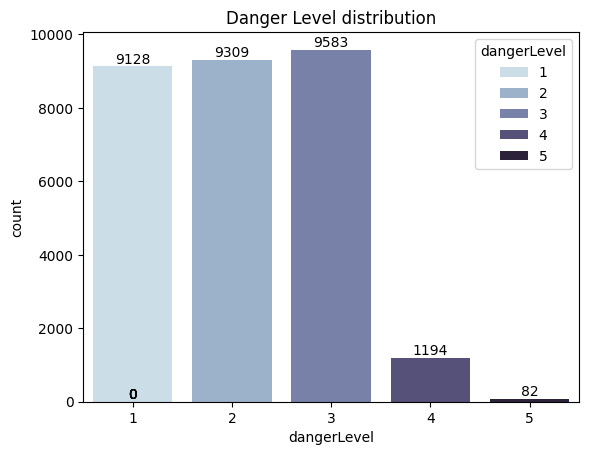

In [10]:
# Danger Level distribution
ax = sns.countplot(data=df, x='dangerLevel', hue='dangerLevel', palette=palette)
plt.title('Danger Level distribution')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.savefig(os.path.join(IMG_DIR, 'danger_level_distribution.png'), bbox_inches='tight')
plt.show()

As we can see, the target variable "*dangerLevel*" is **very imbalanced**.

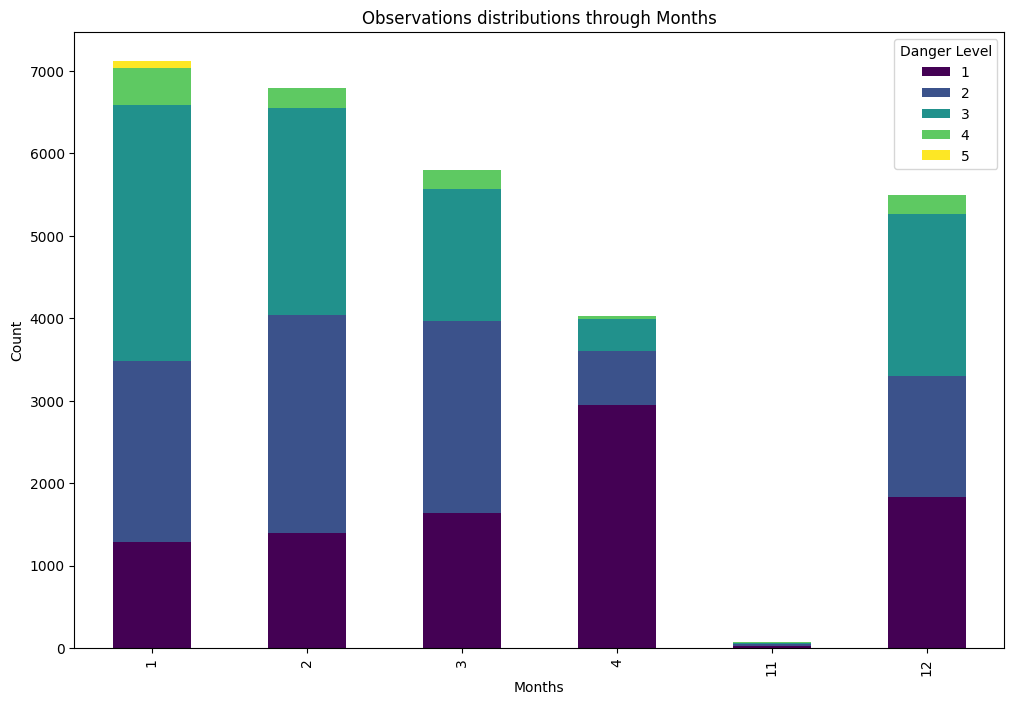

In [11]:
# Generate 'month' column
df['datum'] = pd.to_datetime(df['datum'])
df['month'] = df['datum'].dt.month

# Aggregate data
danger_level_counts = df.groupby(['month', 'dangerLevel']).size().unstack(fill_value=0)

# Plot
ax = danger_level_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.xlabel('Months')
plt.ylabel('Count')
plt.title('Observations distributions through Months')
plt.legend(title='Danger Level')
plt.savefig(os.path.join(IMG_DIR, 'observations_distribution_months.png'), bbox_inches='tight')
plt.show()

Data has been collected only during winter months.

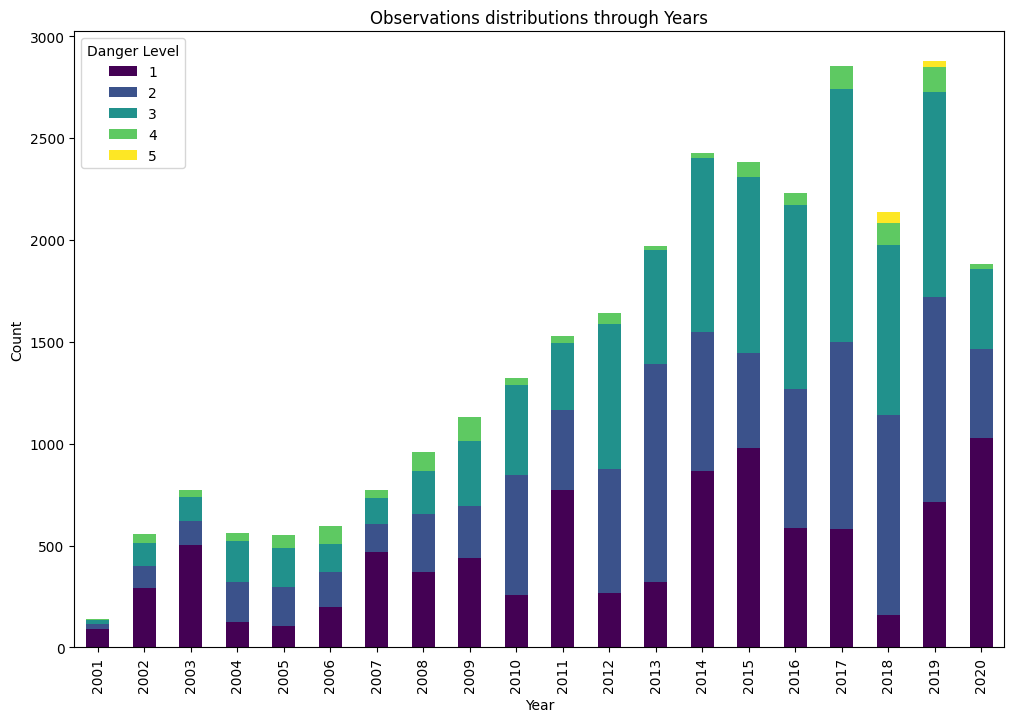

In [12]:
# Generate 'year' column
df['year'] = df['datum'].dt.year

# Aggregate data
danger_level_counts = df.groupby(['year', 'dangerLevel']).size().unstack(fill_value=0)

# Plot
ax = danger_level_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Observations distributions through Years')
plt.legend(title='Danger Level')
plt.savefig(os.path.join(IMG_DIR, 'observations_distribution_years.png'), bbox_inches='tight')
plt.show()

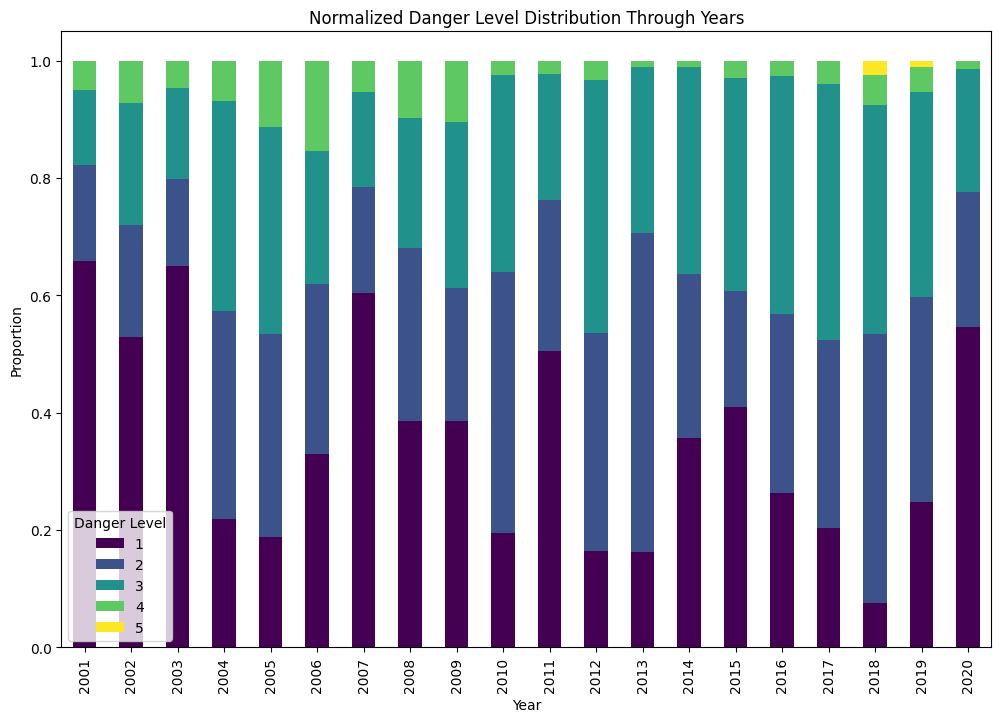

In [13]:
# Normalizzazione dei conteggi per ogni anno
normalized_counts = danger_level_counts.div(danger_level_counts.sum(axis=1), axis=0)

# Plot
ax = normalized_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Normalized Danger Level Distribution Through Years')
plt.legend(title='Danger Level')
plt.savefig(os.path.join(IMG_DIR, 'normalized_danger_level_distribution_years.png'), bbox_inches='tight')
plt.show()

Data has been collected with an overall **increasing frequency** over the years. 

What is interesting to note is that the highest danger level (5) has been assigned only in 2018 and 2019. If we want to avoid data leakage in our model, we should use these years for testing, resulting in a training set with only 4 danger levels (1-4). To ensure all high risk categories are represented in the training set, we can think about **merging the danger levels 4 and 5** into a single class.

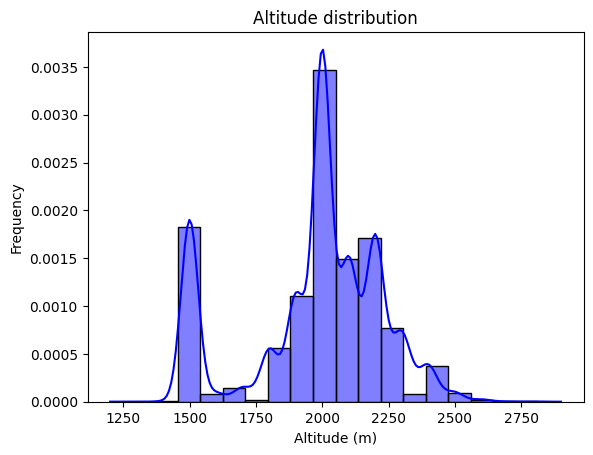

In [14]:
# Altitude distribution
sns.histplot(data=df, x='elevation_th', bins=20, kde=True, color='blue', stat='density')
plt.title('Altitude distribution')
plt.xlabel('Altitude (m)')
plt.ylabel('Frequency')
plt.savefig(os.path.join(IMG_DIR, 'altitude_distribution.png'), bbox_inches='tight')
plt.show()

Data has been mostly collected around 1500 and 2000 meters.

## 1.4 **Missing values**

In [15]:
# Feature overview
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29296 entries, 0 to 29295
Data columns (total 81 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datum                29296 non-null  datetime64[ns]
 1   station_code         29296 non-null  object        
 2   sector_id            29296 non-null  int64         
 3   dangerLevel          29296 non-null  int64         
 4   elevation_th         29284 non-null  float64       
 5   warnreg              29296 non-null  float64       
 6   elevation_station    29296 non-null  float64       
 7   Qs                   29296 non-null  float64       
 8   Ql                   29296 non-null  float64       
 9   Qg_mean              0 non-null      float64       
 10  TSG                  28853 non-null  float64       
 11  Qg0                  29139 non-null  float64       
 12  Qr                   29296 non-null  float64       
 13  OLWR                 29296 non-null 

In [16]:
# Most missing values
empty_attributes = []
for attr, values in df.isna().sum().sort_values(ascending=False).items():
    if values > 0:
        if values == df.shape[0]:
            empty_attributes.append(attr)
        print(f'{attr}:\t{values} ({100 * values / df.shape[0]:.2f}%)')

filtered_df = df.drop(empty_attributes, axis=1)
print(f"\nEmpty attributes: {empty_attributes}")

Qg_mean:	29296 (100.00%)
TS4_mean:	29296 (100.00%)
TS3_mean:	29296 (100.00%)
MS_Soil_Runoff_mean:	29296 (100.00%)
mAlbedo_mean:	29296 (100.00%)
TS2:	4326 (14.77%)
TS1:	4314 (14.73%)
TS0:	4009 (13.68%)
ccl_pwl:	1536 (5.24%)
ccl_pwl_100:	1536 (5.24%)
pwl_100_15:	1531 (5.23%)
ssi_pwl:	1531 (5.23%)
sn38_pwl:	1531 (5.23%)
pwl_100:	1531 (5.23%)
base_pwl:	1531 (5.23%)
sn38_pwl_100:	1531 (5.23%)
sk38_pwl:	1531 (5.23%)
sk38_pwl_100:	1531 (5.23%)
ssi_pwl_100:	1531 (5.23%)
Pen_depth:	1518 (5.18%)
min_ccl_pen:	1465 (5.00%)
Sn:	1187 (4.05%)
Sd:	1187 (4.05%)
Ss:	1074 (3.67%)
S4:	1074 (3.67%)
TSG:	443 (1.51%)
S5:	157 (0.54%)
Qg0:	157 (0.54%)
T_bottom:	32 (0.11%)
TSS_meas:	28 (0.10%)
elevation_th:	12 (0.04%)
TSS_mod:	1 (0.00%)
HN72_24:	1 (0.00%)

Empty attributes: ['Qg_mean', 'TS4_mean', 'TS3_mean', 'MS_Soil_Runoff_mean', 'mAlbedo_mean']


In [17]:
# Number of tuples with no missing values
print(f"Tuples with no missing values: {filtered_df.dropna().shape[0]:,} ({filtered_df.dropna().shape[0] / filtered_df.shape[0] * 100:.2f}%)")

Tuples with no missing values: 22,597 (77.13%)


There are **almost 23% of samples with missing values** besides the empty columns.

## 1.5 **Statistical description**

Now we perform a statistical analysis of the continuous variables.

In [40]:
# Data filtering
numeric_data = filtered_df.select_dtypes(include=['float64']).drop(columns=['warnreg', 'elevation_th', 'elevation_station'])
X = numeric_data

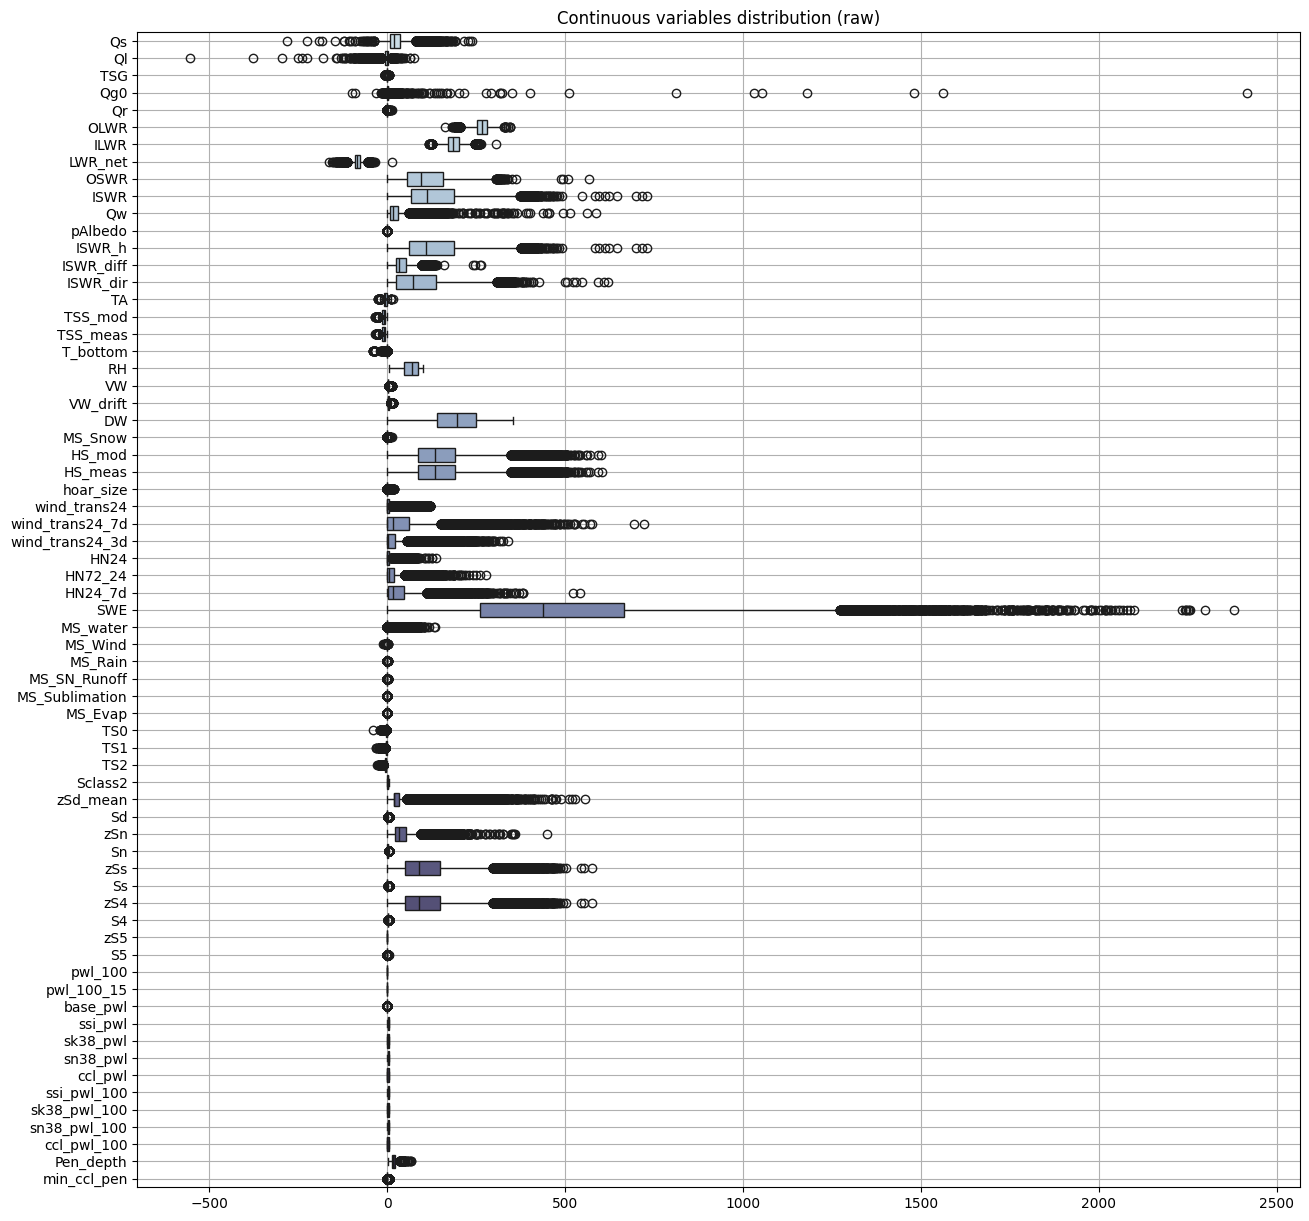

In [44]:
# Continuous attributes box plot
plt.figure(figsize=(15, 15))
sns.boxplot(data=X, orient='h', palette=sns.color_palette("ch:s=.25,rot=-.25", n_colors=len(X.columns)))
plt.xticks(rotation=0)
plt.title('Continuous variables distribution (raw)')
plt.grid(True)
plt.savefig(os.path.join(IMG_DIR, 'continuous_variables_distribution_raw.png'), bbox_inches='tight')
plt.show()

From the boxplot of the continuous variables, we can see that some features have really **different scales**. We can also see that there could be some **outliers** in the data. Let's try to understand them better, using the *Robust Scaler*.

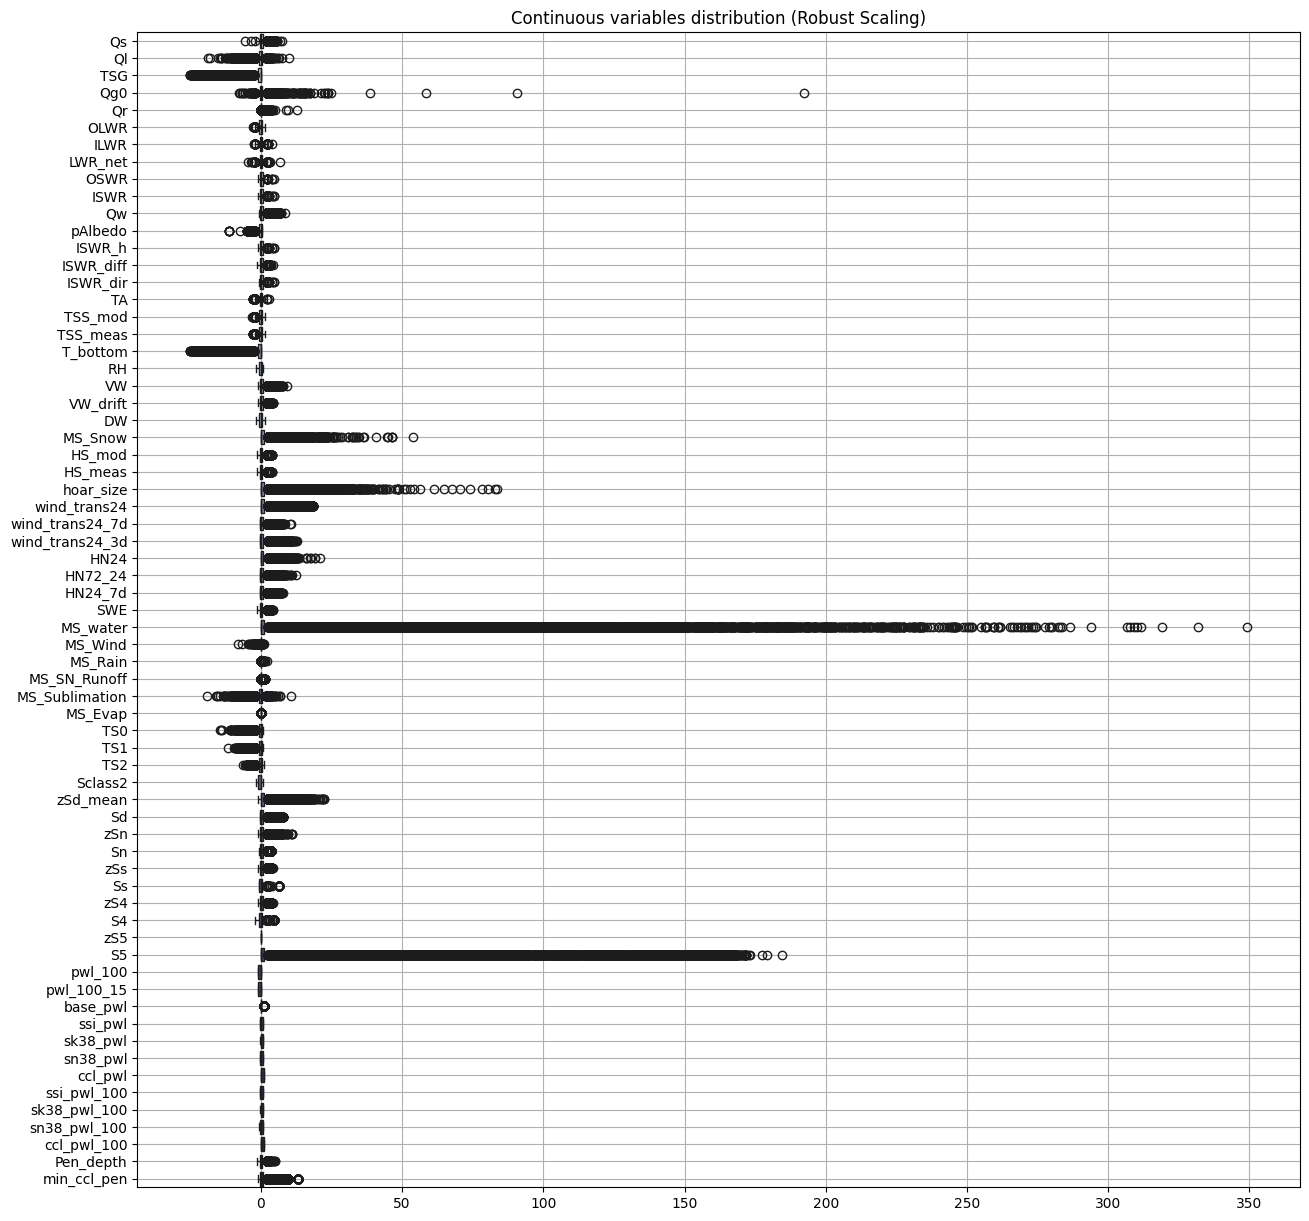

In [45]:
# Robust scaling
scaler = RobustScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(X_scaled, columns=X.columns)

plt.figure(figsize=(15, 15))
sns.boxplot(data=scaled_X, orient='h', palette=sns.color_palette("ch:s=.25,rot=-.25", n_colors=scaled_X.shape[1]))
plt.xticks(rotation=0)
plt.title('Continuous variables distribution (Robust Scaling)')
plt.grid(True)
plt.savefig(os.path.join(IMG_DIR, 'continuous_variables_distribution_robust_scaled.png'), bbox_inches='tight')
plt.show()

*Robust scaler* is a good choice when we have outliers in the data. It scales the data according to the quantile range, so it is less affected by the them. Now, most of the features appear to be less distorted. However, we can still see that someones have a **significative outliers**: _Qg0_, _S5_ and _MS\_water_. In addition, here we can better understand the distribution of the data, observing that some features are really **skewed**, with significant **different distributions** related to the others.

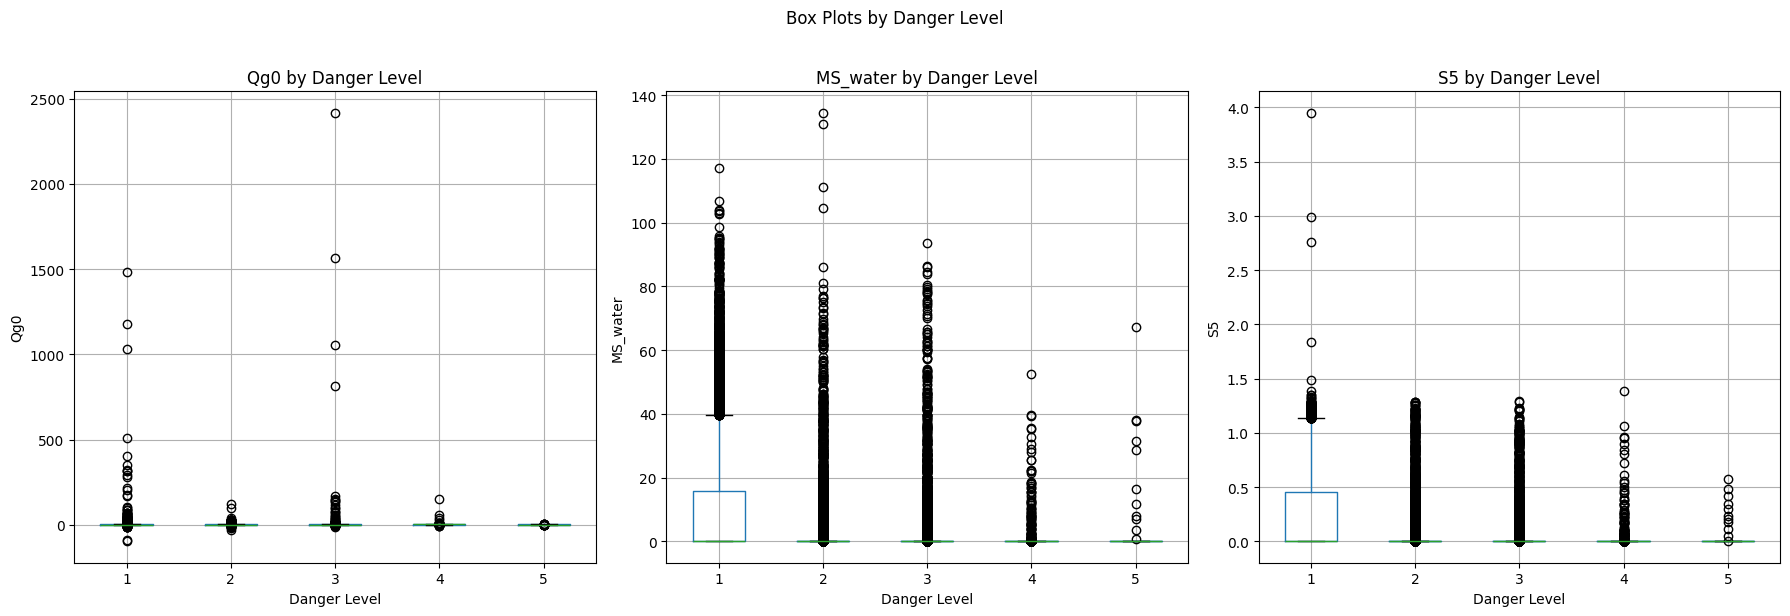

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1
filtered_df.boxplot(column='Qg0', by='dangerLevel', ax=axes[0])
axes[0].set_title('Qg0 by Danger Level')
axes[0].set_xlabel('Danger Level')
axes[0].set_ylabel('Qg0')

# Subplot 2
filtered_df.boxplot(column='MS_water', by='dangerLevel', ax=axes[1])
axes[1].set_title('MS_water by Danger Level')
axes[1].set_xlabel('Danger Level')
axes[1].set_ylabel('MS_water')

# Subplot 3
filtered_df.boxplot(column='S5', by='dangerLevel', ax=axes[2])
axes[2].set_title('S5 by Danger Level')
axes[2].set_xlabel('Danger Level')
axes[2].set_ylabel('S5')

plt.suptitle('Box Plots by Danger Level', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(IMG_DIR, 'box_plots_by_danger_level.png'), bbox_inches='tight')
plt.show()

### 1.5.1 Correlation analysis

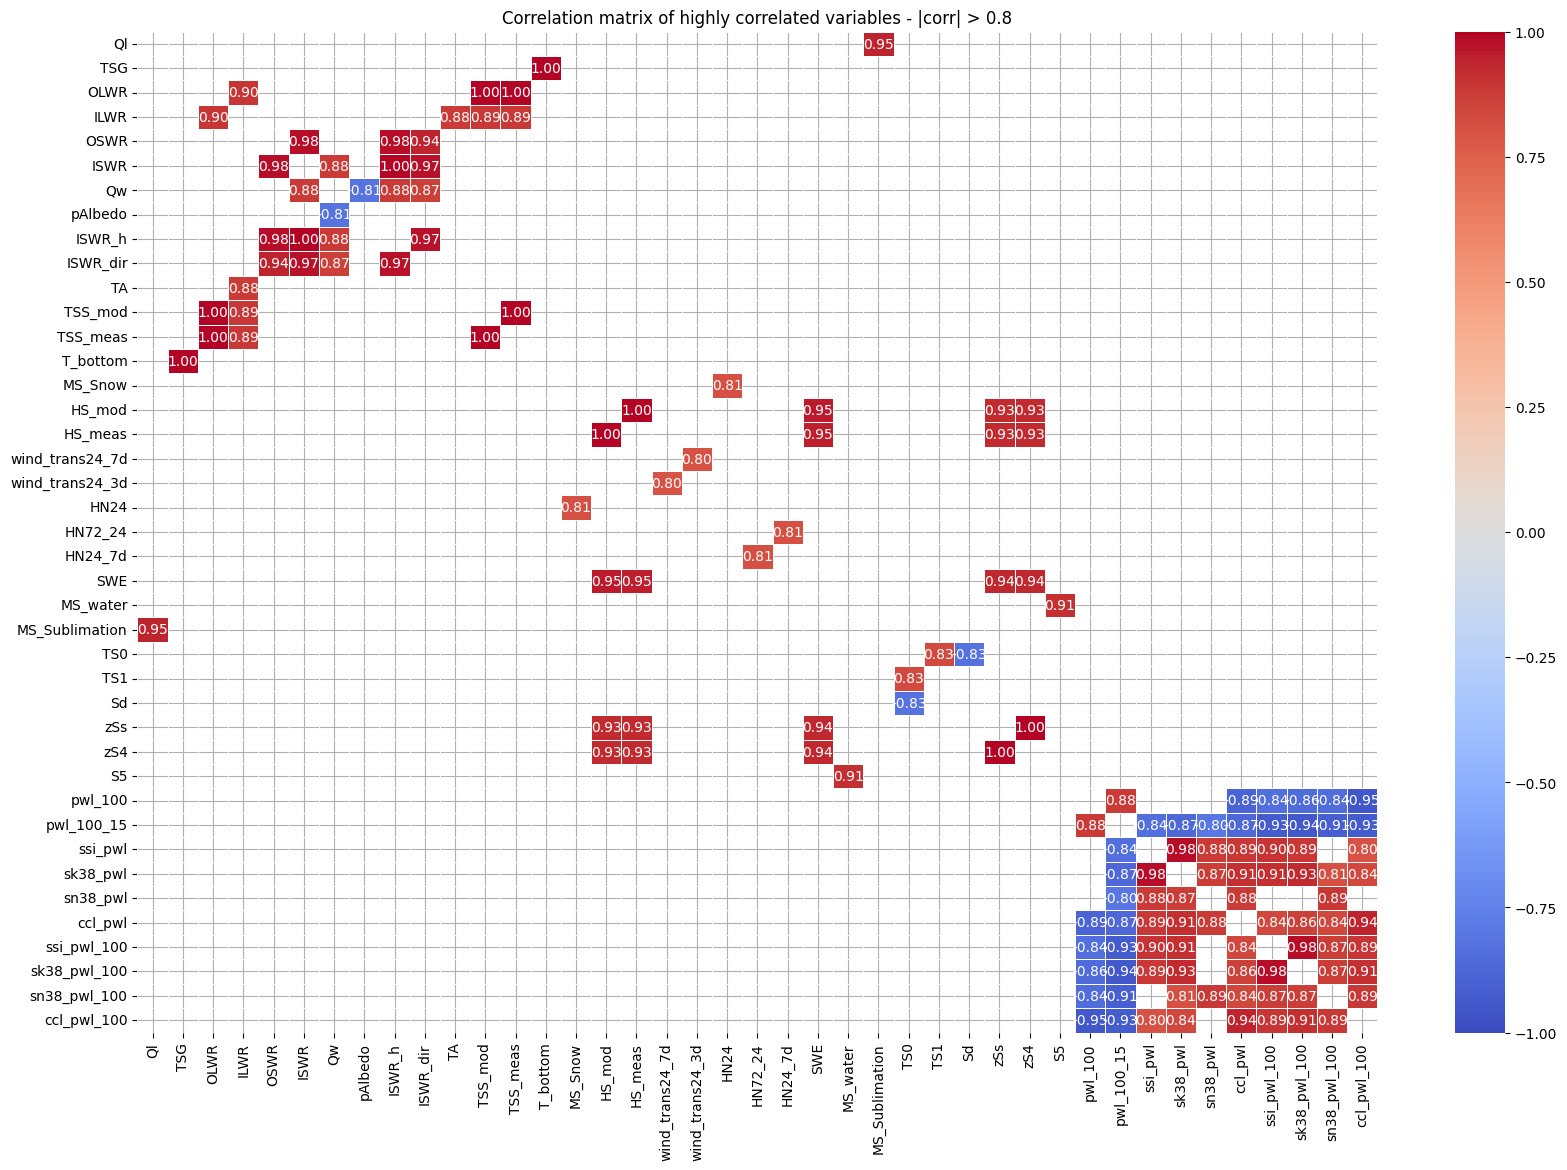

In [22]:
# Correlation matrix
corr_th = 0.8
corr_matrix = X.corr()
mask = np.eye(corr_matrix.shape[0], dtype=bool)
corr_matrix = corr_matrix[((corr_matrix > corr_th) | (corr_matrix < -corr_th)) & ~mask]

filtered_corr_matrix = corr_matrix.drop(columns=corr_matrix.columns[corr_matrix.isna().all()]).drop(index=corr_matrix.index[corr_matrix.isna().all()])
f,ax = plt.subplots(figsize=(20, 13))
ax.set_axisbelow(True)
plt.grid(True)
sns.heatmap(filtered_corr_matrix, 
            annot=True, 
            linewidths=.5, 
            fmt= '.2f',
            ax=ax,
            vmin=-1, 
            vmax=1,
            cmap = "coolwarm")
plt.title(f'Correlation matrix of highly correlated variables - |corr| > {corr_th}')
plt.savefig(os.path.join(IMG_DIR, 'correlation_matrix.png'), bbox_inches='tight')
plt.show()

Observing correlation results, we can see that there are some **highly correlated** features. This can be a problem for some models, for which so we should consider **dropping some of them**. This can be due to the fact that some features are derived from other, or that they are measuring the same thing but in different ways.

#### 1.5.2 PCA

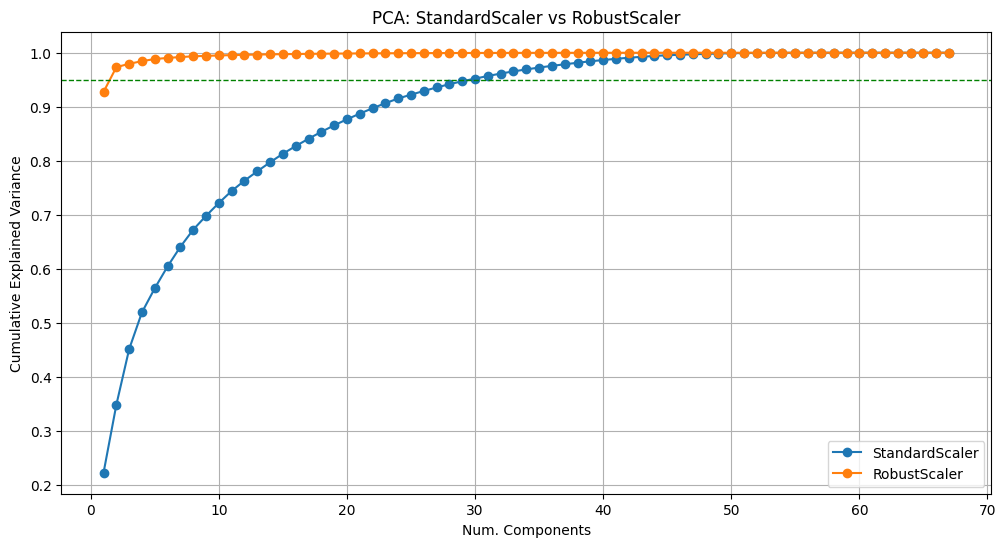

In [23]:
# Scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()
}

plt.figure(figsize=(12, 6))

for scaler_name, scaler in scalers.items():
    # Standardization
    X_scaled = scaler.fit_transform(X)
    
    # PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Cumulative explained variance
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_),
             'o-',
             label=scaler_name)

plt.xlabel('Num. Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: StandardScaler vs RobustScaler')
plt.legend()
plt.grid(True)
plt.axhline(0.95, color='green', linestyle='--', linewidth=1)
plt.grid(True)
plt.savefig(os.path.join(IMG_DIR, 'pca_comparison_scalers.png'), bbox_inches='tight')
plt.show()

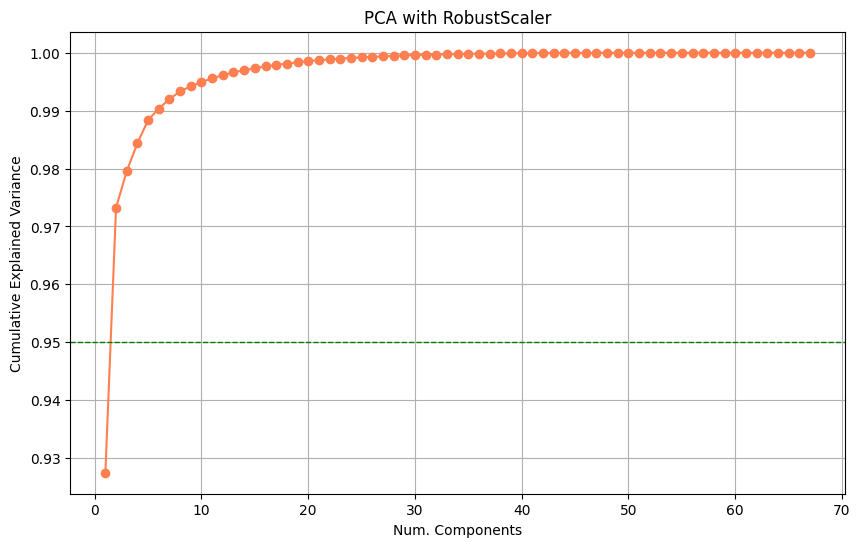

In [ ]:
# Focus on RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 
         'o-', color='coral')
plt.xlabel('Num. Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA with RobustScaler')
plt.grid(True)

plt.axhline(0.95, color='green', linestyle='--', linewidth=1)
plt.grid(True)
plt.savefig(os.path.join(IMG_DIR, 'pca_robust_scaler.png'), bbox_inches='tight')
plt.show()

Applying **RobustScaler** before PCA, concentrates the variance in the first few components: over 97% of it is explained by the fist 2 components, while we reach 99% by 5, whereas using StandardScaler we need to use 30-40 components to reach quite the same amount of variance.

#### 1.5.3 Group-wise PCA

Instead of doing PCA on the whole feature set, we can do it locally on the different groups of highly correlated features.

Let's identify the groups using graph on the correlation matrix:

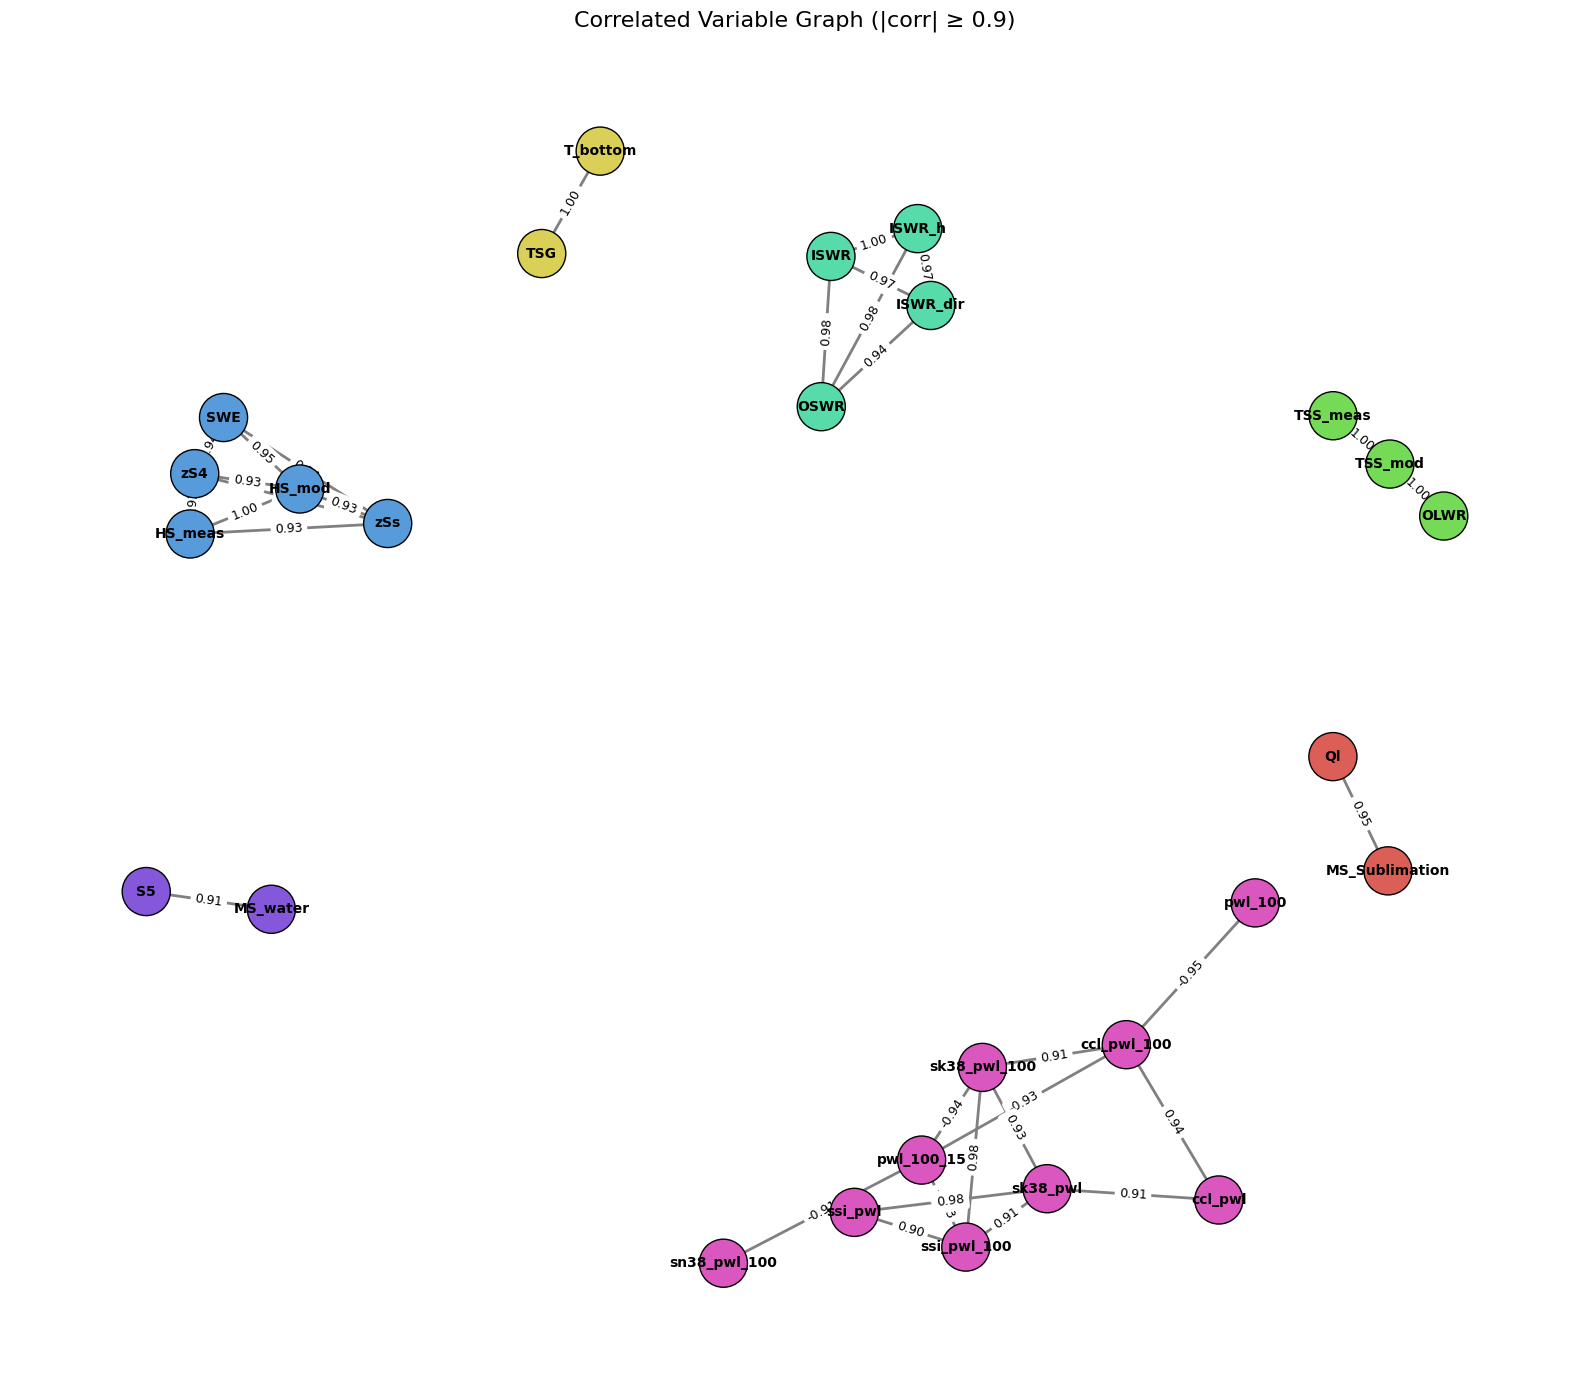

Group 1: ['MS_Sublimation', 'Ql']
Group 2: ['TSG', 'T_bottom']
Group 3: ['OLWR', 'TSS_meas', 'TSS_mod']
Group 4: ['ISWR', 'ISWR_dir', 'ISWR_h', 'OSWR']
Group 5: ['HS_meas', 'HS_mod', 'SWE', 'zS4', 'zSs']
Group 6: ['MS_water', 'S5']
Group 7: ['ccl_pwl', 'ccl_pwl_100', 'pwl_100', 'pwl_100_15', 'sk38_pwl', 'sk38_pwl_100', 'sn38_pwl_100', 'ssi_pwl', 'ssi_pwl_100']


In [25]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

def plot_correlation_graph(G, corr_matrix, threshold=0.8, seed=42):
    """
    Plots a graph of correlated variables using NetworkX.
    Parameters:
    - G: NetworkX graph object
    - corr_matrix: DataFrame containing the correlation matrix
    - threshold: correlation threshold for edge creation
    - seed: random seed for layout
    """
    plt.figure(figsize=(16, 14))
    pos = nx.spring_layout(G, seed=seed, k=0.5)

    # Color map for connected components
    components = list(nx.connected_components(G))
    color_map = sns.color_palette("hls", len(components))
    node_color = {}
    for i, comp in enumerate(components):
        for node in comp:
            node_color[node] = color_map[i]

    # Nodes
    nx.draw_networkx_nodes(G, pos,
                           node_color=[node_color[n] for n in G.nodes()],
                           node_size=1200,
                           edgecolors='k')

    # Edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)

    # Nodes labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Edges labels
    edge_labels = {
        (u, v): f"{corr_matrix.loc[u, v]:.2f}"
        for u, v in G.edges()
        if abs(corr_matrix.loc[u, v]) >= threshold
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                 font_color='black', font_size=9)

    # Plot
    plt.title(f"Correlated Variable Graph (|corr| ≥ {threshold})", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def find_correlated_groups(X, threshold=0.8, seed=42):
    """
    Trova gruppi di feature altamente correlate (|corr| > threshold).
    Restituisce una lista di liste (gruppi).
    """

    # Correlation matrix
    corr_matrix = X.corr()

    # Graph
    edges = [
        (i, j)
        for i in corr_matrix.columns
        for j in corr_matrix.columns
        if i != j and abs(corr_matrix.loc[i, j]) > threshold
    ]
    G = nx.Graph()
    G.add_edges_from(edges)
    # Plot
    # Plot and save the correlation graph
    plt.ioff()  # Turn off interactive mode to avoid double display
    plot_correlation_graph(G, corr_matrix, threshold=threshold, seed=seed)
    plt.savefig(os.path.join(IMG_DIR, f'correlation_graph_thr_{threshold}.png'), bbox_inches='tight')
    plt.ion()   # Restore interactive mode

    # Connected components
    groups = list(nx.connected_components(G))

    return [sorted(list(group)) for group in groups if len(group) > 1]

# Find correlated groups
groups = find_correlated_groups(X, threshold=0.90, seed=0)
for i, group in enumerate(groups, 1):
    print(f"Group {i}: {group}")


We can understand how much they are correlated within each group:

<Figure size 640x480 with 0 Axes>

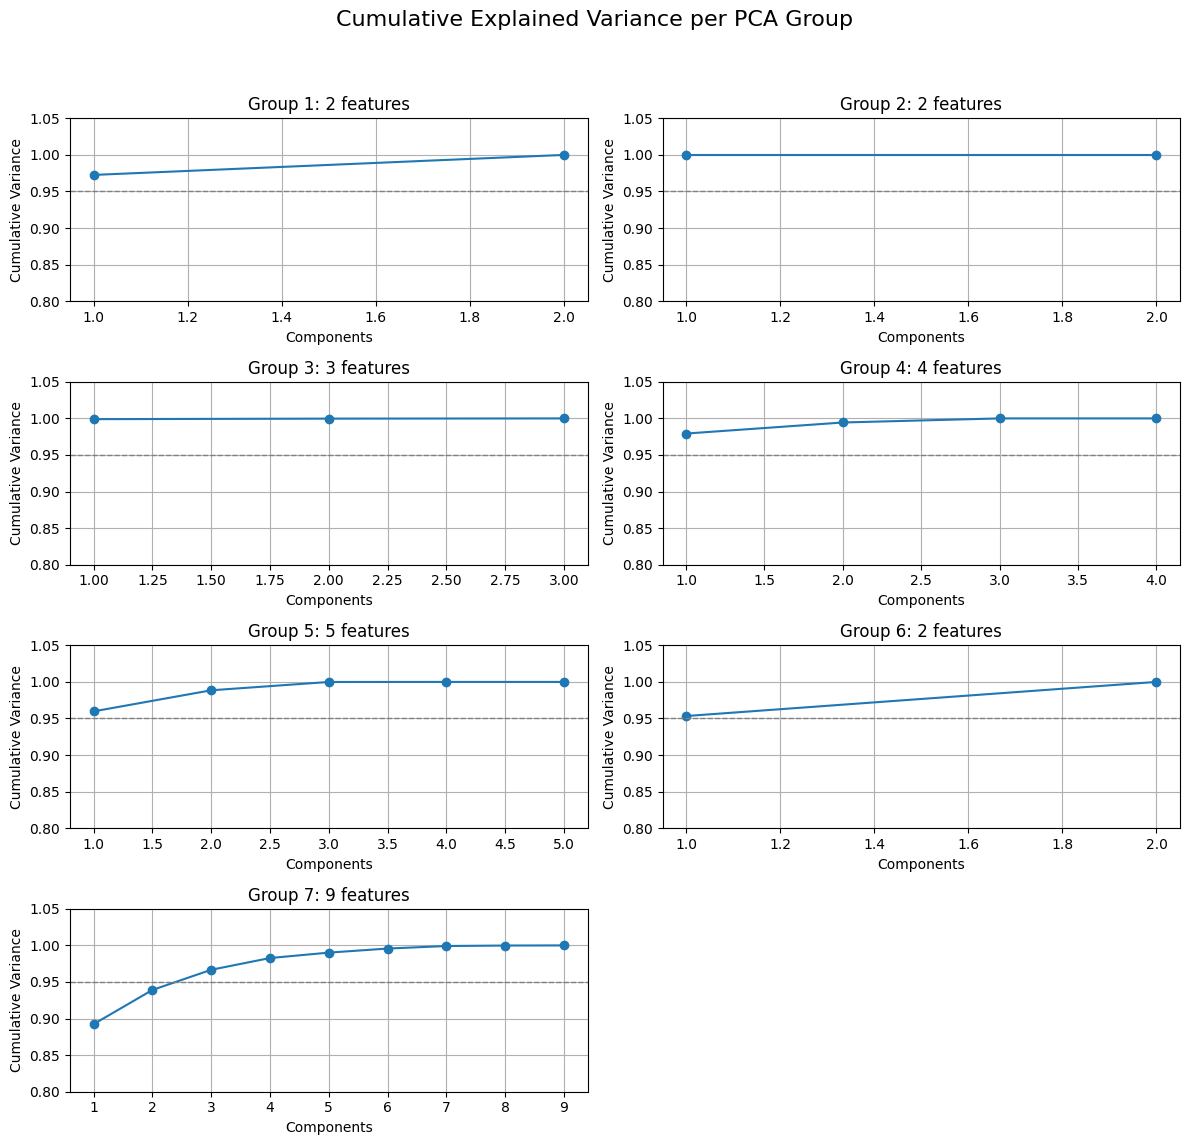

In [26]:
def plot_groups_cumul_var(X, groups, figsize=(12, 12)):
    """
    Plots the cumulative explained variance for each group of features.
    """
    # Number of groups
    n_groups = len(groups)
    n_cols = 2
    n_rows = (n_groups + 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
    fig.suptitle("Cumulative Explained Variance per PCA Group", fontsize=16)
    for i, group in enumerate(groups):
        ax = axes[i // n_cols][i % n_cols]
        X_grp = X[group].dropna()
        X_scaled = StandardScaler().fit_transform(X_grp)
        pca = PCA().fit(X_scaled)
        cum_var = pca.explained_variance_ratio_.cumsum()

        ax.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
        ax.set_ylim(0.8, 1.05)
        ax.set_title(f"Group {i+1}: {len(group)} features")
        ax.set_xlabel("Components")
        ax.set_ylabel("Cumulative Variance")

        ax.axhline(0.95, color='gray', linestyle='--', linewidth=1)
        ax.grid(True)

    # Hide empty subplots
    for j in range(i+1, n_rows * n_cols):
        axes[j // n_cols][j % n_cols].axis('off')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(IMG_DIR, 'cumulative_variance_per_group.png'), bbox_inches='tight')
    plt.show()

plot_groups_cumul_var(X, groups)

Let's save them for later use:

In [31]:
records = []
for i, group in enumerate(groups, start=1):
    for feature in group:
        records.append({"group_id": f"group_{i}", "feature_name": feature})
df = pd.DataFrame(records)
df.to_csv(os.path.join(CSV_DIR, 'correlated_features_groups.csv'), index=False)
print(f"Saved {len(groups)} groups of correlated features.")

Saved 7 groups of correlated features.


---

## 1.6 Exploration results

- The dataset contains an high number of features (79), mostly continuous.- The target variable (**dangerLevel**) is **strongly imbalanced** with 4 (High) and 5 (Very High) significantly underepresented.
- **Data is seasonally concentrated**, with observations available only between _November_ to _April_.
- 22.87% of the records contain at least one missing value; however, **77.13% of the dataset is complete**.
- Some features contain **only missing values** or show **near-zero variance**, making them uninformative for modeling.
- Several features present **significant outliers** and **highly skewed distributions**.
- A number of variables are **strongly correlated**, suggesting potential redundancy.
- Some features describe **station-specific** or **regional identifiers** (e.g., *station_code*, *sector_id*), which should be excluded from modeling to avoid introducing location-dependent bias. The objective is to develop a generalizable, location-independent model.